In [215]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
data = pd.read_csv('data/chicago.csv')

# Contextual Activity
context_data = data[['Case ID', '(case) customer:age', '(case) customer:currently_student', '(case) customer:household_income',
                    '(case) customer:employment_status', '(case) customer:disabled']]

# Journey Data
all_activities = pd.unique(data['Activity'])
activity_encoder = dict(zip(all_activities,range(3,len(all_activities) + 3)))
activity_encoder['Start'] = 1
activity_encoder['End'] = 2
journeys_data = data[['Case ID','Activity']]
journeys_data['Activity Label'] = journeys_data['Activity'].apply(lambda x: activity_encoder[x])
journeys_data = journeys_data.groupby(['Case ID'])['Activity Label'].apply(list)
journeys_data = journeys_data.reset_index(name="Activity")
journeys_data['Activity'] = journeys_data['Activity'].apply(lambda x: [1] + x + [2])
journey_vecs = keras.preprocessing.sequence.pad_sequences(journeys_data['Activity'], padding='post')

/Users/justinlee/Desktop/Master/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [216]:
context = data[['(case) time:DATE_day_of_week_0_is_monday', '(case) customer:employed',
               '(case) customer:currently_student', '(case) customer:valid_license']]
context = pd.get_dummies(context, columns=['(case) time:DATE_day_of_week_0_is_monday', '(case) customer:employed',
                                          '(case) customer:currently_student','(case) customer:valid_license'])
context = pd.concat([data['Case ID'], context], axis=1)
context.drop_duplicates(subset='Case ID', inplace=True)
context.reset_index(inplace=True)

In [217]:
from sklearn.model_selection import train_test_split
id_train, id_test = train_test_split(journeys_data['Case ID'], test_size=0.2)

In [218]:
# Many to one + context
def mto_lstm_prep(journey):
    inp = [journey[:i] for i in range(1,len(journey))]
    out = journey[1:]
    return (inp,out)

def make_data(id_indexes, journey_df, context_df):
    X_j = []
    Y = []
    X_c = []

    selected = journey_df.iloc[id_indexes]

    for index, row in selected.iterrows():
        inp, out = mto_lstm_prep(row['Activity'])
        rep = len(inp)
        c = context_df.iloc[index].drop(labels=['index','Case ID']).to_numpy()
        c = np.tile(c, (rep, 1))
        X_j.extend(inp)
        Y.extend(out)
        X_c.extend(c)
    X_j = keras.preprocessing.sequence.pad_sequences(X_j, padding='pre')
    X_c = np.asarray(X_c).astype("float32")
    Y = np.asarray(Y).astype("float32")
    return (X_j, X_c, Y)

In [219]:
X_j_train, X_c_train, Y_train = make_data(id_train.index, journeys_data, context)
X_j_test, X_c_test, Y_test = make_data(id_test.index, journeys_data, context)

# Baseline

In [53]:
from sklearn.metrics import f1_score, accuracy_score
# For some given group, always take the most popular activity at each time step
# Post padding is ok here since we are looking for plain activity indexed by time
test_pop = journeys_data['Activity'].iloc[id_test.index]
test_pop = keras.preprocessing.sequence.pad_sequences(test_pop, padding='post')

# Finding the most popular activities
pop_accs = []
for i in range(test_pop.shape[1]):
    curr_accs = test_pop[:,i]
    pop_acc = np.argmax(np.bincount(test_pop[:,i]))
    pop_accs.append(pop_acc)
    
# Finding the correct indices to make baseline Y's
indices = np.sum(np.where(X_j_test >= 1, 1, 0), axis=1)
Y_baseline = [pop_accs[i] for i in indices]

print("f1:", f1_score(Y_test, Y_baseline, average='weighted'))
print("accuracy:", accuracy_score(Y_test, Y_baseline))

f1: 0.46212465260292745
accuracy: 0.46550766314826314


# Many to One LSTM

In [260]:
lstm_dim = 128
timesteps = X_j_train.shape[1]
context_dim = X_c_train.shape[1]
output_dim = len(activity_encoder) + 1

input_journey = layers.Input(shape=(timesteps, 1))
input_context = layers.Input(shape=(context_dim,))

lstm = layers.LSTM(lstm_dim, recurrent_dropout=0.5)(input_journey)
dense = layers.Dense(3, activation="relu")(input_context)
merged = layers.Concatenate()([dense, lstm])
softmax = layers.Dense(output_dim, activation="softmax")(merged)
model = keras.Model([input_journey, input_context], softmax)
model.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
dense_94 (Dense)                (None, 3)            57          input_71[0][0]                   
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 128)          66560       input_70[0][0]                   
___________________________________________________________________________________________

In [261]:
from sklearn.model_selection import train_test_split
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy')
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit([X_j_train, X_c_train], Y_train, validation_split=0.2, batch_size=32, epochs=75, callbacks=callback)

Epoch 1/75
3063/3063 [==============================] - 40s 13ms/step - loss: 1.3490 - val_loss: 1.0896
Epoch 2/75
3063/3063 [==============================] - 40s 13ms/step - loss: 1.0833 - val_loss: 1.0595
Epoch 3/75
3063/3063 [==============================] - 40s 13ms/step - loss: 1.0531 - val_loss: 1.0457
Epoch 4/75
3063/3063 [==============================] - 41s 13ms/step - loss: 1.0392 - val_loss: 1.0391
Epoch 5/75
3063/3063 [==============================] - 41s 13ms/step - loss: 1.0381 - val_loss: 1.0313
Epoch 6/75
3063/3063 [==============================] - 42s 14ms/step - loss: 1.0346 - val_loss: 1.0284
Epoch 7/75
3063/3063 [==============================] - 41s 13ms/step - loss: 1.0220 - val_loss: 1.0256
Epoch 8/75
3063/3063 [==============================] - 42s 14ms/step - loss: 1.0158 - val_loss: 1.0236
Epoch 9/75
3063/3063 [==============================] - 41s 13ms/step - loss: 1.0201 - val_loss: 1.0193
Epoch 10/75
3063/3063 [==============================] - 42s 14m

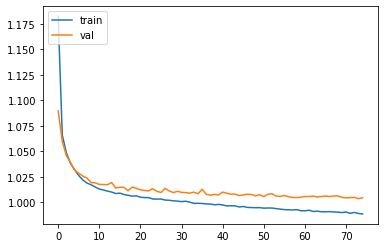

In [262]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')

In [263]:
preds = model.predict([X_j_test, X_c_test])

In [264]:
X_c_test.shape

(30755, 18)

In [265]:
accs = np.argmax(preds, axis=1)

In [266]:
from sklearn.metrics import f1_score, accuracy_score
print("f1:", f1_score(Y_test, accs, average='weighted'))
print("accuracy:", accuracy_score(Y_test, accs))

f1: 0.6631600991204788
accuracy: 0.734742318322224


### Generating Conditional Journeys

In [286]:
from sklearn.preprocessing import normalize
activity_decoder = {j:i for i,j in activity_encoder.items()}
def sample_activity(probs, mode="max"):
    if mode == "max":
        return np.argmax(probs)
    elif mode =="multi":
        return np.argmax(np.random.multinomial(1, probs))
    else:
        return
        
def generate(context, model, decode="off"):
    seed = [1]
    context = context.reshape(1,context.shape[0])
    for i in range(16):
        seed_padded = keras.preprocessing.sequence.pad_sequences([seed], maxlen=16, padding='pre')
        probs = model.predict([seed_padded, context])[0]
        probs = np.asarray(probs).astype('float64')
        probs = probs / np.sum(probs)
        activity = sample_activity(probs, mode="multi")
        seed.append(activity)
    if decode == "on":
        seed = [activity_decoder[s] for s in seed]
    return seed

In [312]:
X_c_test_ = context.iloc[id_test.index]
X_j_test_ = journeys_data.iloc[id_test.index]
sample_c = X_c_test.iloc[12].drop(labels=['index', 'Case ID']).to_numpy().astype("float32")
generate(sample_c, model, decode="on")

['Start',
 'All other home activities',
 'Recreation/Entertainment',
 'All other home activities',
 'End',
 'End',
 'Picked up passenger',
 'All other home activities',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End']

In [313]:
[activity_decoder[i] for i in X_j_test_.iloc[12]['Activity']]

['Start',
 'All other home activities',
 'Recreation/Entertainment',
 'Eat meal outside of home',
 'All other home activities',
 'End']

# Conditional Temporal VAE

### Encoder

In [224]:
lstm_dim = 128
latent_dim = 3
c_dim = 3
batch_size = 16
timesteps = X_j_train.shape[1]
context_dim = X_c_train.shape[1]
output_dim = len(activity_encoder) + 1


class Sample(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

input_j = layers.Input(shape=(timesteps, 1))
input_c = layers.Input(shape=(context_dim))

lstm = layers.LSTM(lstm_dim)(input_j)

c_pos_mean = layers.Dense(latent_dim)(input_c)
c_pos_log_var = layers.Dense(latent_dim)(input_c)

c_concat = layers.Concatenate()([c_pos_mean, lstm])
prior_mean_linear = layers.Dense(latent_dim)(c_concat)
prior_log_var = layers.Dense(latent_dim)(c_concat)

pos_mean_linear = layers.Dense(latent_dim)(c_concat)
pos_mean = layers.BatchNormalization()(pos_mean_linear)
pos_log_var = layers.Dense(latent_dim)(c_concat)

z_pos = Sample()([pos_mean, pos_log_var])
z_cpos = Sample()([c_pos_mean, c_pos_log_var])

encoder = keras.Model([input_j, input_c],
                      [z_pos, pos_mean, pos_log_var, 
                       prior_mean_linear, prior_log_var,
                       z_cpos, c_pos_mean, c_pos_log_var])
encoder.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 3)            57          input_64[0][0]                   
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 128)          66560       input_63[0][0]                   
___________________________________________________________________________________________

### Time Varying Decoder

In [225]:
input_z = layers.Input(shape=(latent_dim,))
input_c_z = layers.Input(shape=(latent_dim,))
merge = layers.Concatenate()([input_z, input_c_z])
output = layers.Dense(output_dim, activation="softmax")(input_z)
output = layers.Dropout(0.5)(output)
decoder = keras.Model([input_z, input_c_z], output)
decoder.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_90 (Dense)                (None, 18)           72          input_65[0][0]                   
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 18)           0           dense_90[0][0]                   
Total params: 72
Trainable params: 72
Non-trainable params: 0
_____________________________

### Context Decoder

In [226]:
input_c_z = layers.Input(shape=(latent_dim,))
output = layers.Dense(context_dim, activation="softmax")(input_c_z)
output = layers.Dropout(0.5)(output)
context_decoder = keras.Model(input_c_z, output)
context_decoder.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_91 (Dense)             (None, 18)                72        
_________________________________________________________________
dropout_20 (Dropout)         (None, 18)                0         
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________


In [227]:
import tensorflow.keras.backend as K
from keras.callbacks import Callback

def custom_KL(posterior_means, prior_means, posterior_log_var, prior_log_var):
    # KL of p under q    
    kl = prior_log_var - posterior_log_var + (tf.exp(posterior_log_var) + 
                                       tf.square(posterior_means - prior_means)) / tf.exp(prior_log_var) - 1
    kl = 0.5 * tf.reduce_sum(kl, axis=1)
    return kl

# total number of epochs
n_epochs = 75
# The number of epochs at which KL loss should be included
klstart = 15
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 10

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(K.get_value(self.weight) + (1./ kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))

class RVAE(keras.Model):
    def __init__(self, encoder, decoder, c_decoder,**kwargs):
        super(RVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.c_decoder = c_decoder
    def compile(self, optimizer, beta):
        super(RVAE, self).compile()
        self.optimizer = optimizer
        self.beta = beta
        
    def train_step(self,data):
        if isinstance(data, tuple):
            journeys, contexts = data[0]
            output = data[1]
        
        with tf.GradientTape() as tape:
            z, pos_means, pos_log_var, prior_means, \
            prior_log_var, z_cpos, c_pos_means, c_pos_log_var= self.encoder([journeys, contexts])
            pred_activity = self.decoder([z, z_cpos])
            pred_context = self.c_decoder(z_cpos)
            
            journey_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.sparse_categorical_crossentropy(output, pred_activity))
            )
                        
            t_kl_divergence =   tf.reduce_mean(
                custom_KL(pos_means, prior_means, pos_log_var, prior_log_var)
            )
            
            c_kl_divergence = tf.reduce_mean(
                custom_KL(c_pos_means, prior_means, c_pos_log_var, prior_log_var)
            )
            
            context_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(contexts, pred_context)
            )

            total_loss = journey_loss + context_loss + self.beta * (t_kl_divergence + c_kl_divergence)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "journey_loss":journey_loss,
            "t_kl_divergence": t_kl_divergence,
            "c_divergence": c_kl_divergence,
        }
     
    def test_step(self, data):
        journeys, contexts = data[0]
        outputs = data[1]
        pred_activity, pred_context = self([journeys, contexts], training=False)
        journey_loss = tf.keras.losses.sparse_categorical_crossentropy(outputs, pred_activity)
        context_loss = tf.keras.losses.binary_crossentropy(contexts, pred_context)
        return {
            "journey_loss": journey_loss,
            "context_loss": context_loss
        }
            
    def call(self, data):
        journeys, contexts = data
        z, pos_means, pos_log_var, prior_means, \
        prior_log_var, z_cpos, c_pos_means, c_pos_log_var= self.encoder([journeys, contexts])
        return(self.decoder([z, z_cpos]), self.c_decoder(z_cpos))
    
        
            

In [228]:
weight = K.variable(0.)
weight._trainable = False
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
rvae = RVAE(encoder, decoder, context_decoder)
rvae.compile(optimizer=keras.optimizers.Adam(lr=0.0001), beta=weight)
history = rvae.fit([X_j_train, X_c_train], Y_train, validation_split=0.2, epochs=n_epochs, 
                   batch_size=32, callbacks=[AnnealingCallback(weight)])


Epoch 1/75
3063/3063 [==============================] - 25s 8ms/step - loss: 60.3232 - journey_loss: 59.6421 - t_kl_divergence: 56.9470 - c_divergence: 3.1600 - val_journey_loss: 1.3110 - val_context_loss: 0.6203
Current KL Weight is 0.0
Epoch 2/75
3063/3063 [==============================] - 24s 8ms/step - loss: 43.7477 - journey_loss: 43.1555 - t_kl_divergence: 64.2409 - c_divergence: 2.7830 - val_journey_loss: 1.0812 - val_context_loss: 0.5575
Current KL Weight is 0.0
Epoch 3/75
3063/3063 [==============================] - 25s 8ms/step - loss: 40.6797 - journey_loss: 40.1439 - t_kl_divergence: 59.7025 - c_divergence: 4.0805 - val_journey_loss: 1.0322 - val_context_loss: 0.5165
Current KL Weight is 0.0
Epoch 4/75
3063/3063 [==============================] - 24s 8ms/step - loss: 39.5191 - journey_loss: 39.0129 - t_kl_divergence: 62.3216 - c_divergence: 6.1994 - val_journey_loss: 1.0326 - val_context_loss: 0.4927
Current KL Weight is 0.0
Epoch 5/75
3063/3063 [==========================

3063/3063 [==============================] - 23s 7ms/step - loss: 37.8842 - journey_loss: 34.6103 - t_kl_divergence: 1.9940 - c_divergence: 0.7195 - val_journey_loss: 0.8659 - val_context_loss: 0.5927
Current KL Weight is 1.0
Epoch 70/75
3063/3063 [==============================] - 22s 7ms/step - loss: 37.8776 - journey_loss: 34.6092 - t_kl_divergence: 1.9905 - c_divergence: 0.7180 - val_journey_loss: 0.8598 - val_context_loss: 0.5688
Current KL Weight is 1.0
Epoch 71/75
3063/3063 [==============================] - 23s 7ms/step - loss: 37.8786 - journey_loss: 34.5978 - t_kl_divergence: 2.0006 - c_divergence: 0.7205 - val_journey_loss: 0.8817 - val_context_loss: 0.5508
Current KL Weight is 1.0
Epoch 72/75
3063/3063 [==============================] - 23s 7ms/step - loss: 37.8539 - journey_loss: 34.5879 - t_kl_divergence: 1.9862 - c_divergence: 0.7205 - val_journey_loss: 0.8103 - val_context_loss: 0.5638
Current KL Weight is 1.0
Epoch 73/75
3063/3063 [==============================] - 23s

In [1]:
from sklearn.metrics import f1_score, accuracy_score

activities, contexts  = rvae.predict([X_j_test, X_c_test])
activities = np.argmax(activities, axis=1)
print("f1:", f1_score(Y_test, activities, average='weighted'))
print("accuracy:", accuracy_score(Y_test, activities))

NameError: name 'rvae' is not defined

In [230]:
z_pos, pos_mean, pos_log_var, prior_mean_linear, prior_log_var, z_cpos, c_pos_means, c_pos_log_var = encoder([X_j_test, X_c_test])

In [231]:
predictions = decoder.predict([prior_mean_linear, c_pos_means])

In [232]:
activities = np.argmax(predictions, axis=1)
print("f1:", f1_score(Y_test, activities, average='weighted'))
print("accuracy:", accuracy_score(Y_test, activities))

f1: 0.5877686756010602
accuracy: 0.6384978052349212


In [162]:
stochastic_preds = []
for i in range(1):
    mu = prior_mean_linear[i].numpy()
    mu = np.tile(mu, (100,1))
    log_var = prior_log_var[i].numpy()
    log_var = np.tile(log_var, (100,1))
    mvn_mu = np.zeros(7)
    mvn_cov = np.identity(7)
    epsilon = np.random.multivariate_normal(mvn_mu, mvn_cov,size = 100)
    z = np.exp(0.5 * log_var) * epsilon + mu
    c = np.tile(c_pos_means[i].numpy(), (100,1))
    sample = decoder.predict([z, c])
    activities = np.argmax(sample, axis=1)
    print(activities)

[5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3
 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5
 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3]


In [247]:
from sklearn.preprocessing import normalize
activity_decoder = {j:i for i,j in activity_encoder.items()}
def sample_activity(probs, mode="max"):
    if mode == "max":
        return np.argmax(probs)
    elif mode =="multi":
        return np.argmax(np.random.multinomial(1, probs))
    else:
        return
        
def vrnn_generate(context, encoder, decoder, decode="off"):
    seed = [1]
    context = context.reshape(1,context.shape[0])
    for i in range(16):
        seed_padded = keras.preprocessing.sequence.pad_sequences([seed], maxlen=16, padding='pre')
        
        z_pos, pos_mean, pos_log_var, prior_mean_linear,\
        prior_log_var, z_cpos, c_pos_means,c_pos_log_var = encoder([seed_padded, context])
        
        probs = decoder.predict([prior_mean_linear, c_pos_means])[0]
        probs = np.asarray(probs).astype('float64')
        probs = probs / np.sum(probs)
        activity = sample_activity(probs, mode="max")
        seed.append(activity)
    if decode == "on":
        seed = [activity_decoder[s] for s in seed]
    return seed

In [253]:
vrnn_generate(X_c_test[0], encoder, decoder, decode="on")

['Start',
 'All other home activities',
 'Routine Shopping',
 'All other home activities',
 'Routine Shopping',
 'All other home activities',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End',
 'End']

In [255]:
X_j_test[5]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 3, 5, 3], dtype=int32)

In [256]:
X_c_test[0]

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1.], dtype=float32)